In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('Downloads/CSVs/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data[' Flow Packets/s'] = data[' Flow Packets/s'].astype('float64')
data['Flow Bytes/s'] = data['Flow Bytes/s'].astype('float64')
data[' Timestamp'] = pd.to_datetime(data[' Timestamp'], format = '%m/%d/%Y %H:%M')
data = data.replace([np.inf, -np.inf], np.nan)

In [4]:
src_ip_num = data[' Source IP'].str.split('.', expand = True)
src_ip_num.columns = ['src_a', 'src_b', 'src_c','src_d']
src_ip_num = src_ip_num.applymap(int)
dest_ip_num = data[' Destination IP'].str.split('.', expand = True)
dest_ip_num.columns = ['dest_a', 'dest_b', 'dest_c','dest_d']
dest_ip_num = dest_ip_num.applymap(int)

In [5]:
data = data.merge(dest_ip_num, left_index = True, right_index = True)
data = data.merge(src_ip_num, left_index = True, right_index = True)

In [6]:
data['time_diff'] = (data[' Timestamp'] - data[' Timestamp'].shift(1)).astype('timedelta64[s]')

In [7]:
non_trainable = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', 'External IP', ' Label', 'dest_a','dest_b','dest_c','dest_d','src_a','src_b', 'src_c','src_d']

In [8]:
train = data[data[' Timestamp'] < '2017-07-07 04:15:00']

In [9]:
test = data[data[' Timestamp'] >= '2017-07-07 04:15:00']

In [10]:
len(test) / len(data)

0.17103811823074708

In [11]:
sum(test[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0))

4307

In [12]:
scaler = StandardScaler()

In [13]:
scaled_train_X = scaler.fit_transform(train[[column for column in train.columns if column not in non_trainable]].fillna(0))

In [14]:
scaled_test_X = scaler.transform(test[[column for column in test.columns if column not in non_trainable]].fillna(0))

In [15]:
train_Y = train[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0)

In [16]:
test_Y = test[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0)

In [264]:
scaled_train_X = scaled_train_X.reshape((scaled_train_X.shape[0], 1, scaled_train_X.shape[1]))
scaled_test_X = scaled_test_X.reshape((scaled_test_X.shape[0], 1, scaled_test_X.shape[1]))

In [233]:
%matplotlib inline

/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 187134 samples, validate on 38611 samples
Epoch 1/50
 - 8s - loss: 0.2234 - val_loss: 0.1857
Epoch 2/50
 - 7s - loss: 0.0953 - val_loss: 0.2071
Epoch 3/50
 - 7s - loss: 0.0765 - val_loss: 0.2245
Epoch 4/50
 - 10s - loss: 0.0765 - val_loss: 0.1982
Epoch 5/50
 - 10s - loss: 0.0874 - val_loss: 0.1710
Epoch 6/50
 - 9s - loss: 0.0746 - val_loss: 0.1775
Epoch 7/50
 - 8s - loss: 0.0709 - val_loss: 0.1683
Epoch 8/50
 - 8s - loss: 0.0817 - val_loss: 0.1491
Epoch 9/50
 - 8s - loss: 0.0823 - val_loss: 0.1449
Epoch 10/50
 - 7s - loss: 0.0685 - val_loss: 0.0425
Epoch 11/50
 - 7s - loss: 0.0844 - val_loss: 0.1363
Epoch 12/50
 - 9s - loss: 0.0787 - val_loss: 0.1362
Epoch 13/50
 - 8s - loss: 0.0792 - val_loss: 0.1608
Epoch 14/50
 - 9s - loss: 0.0705 - val_loss: 0.0215
Epoch 15/50
 - 8s - loss: 0.0690 - val_loss: 0.0197
Epoch 16/50
 - 8s - loss: 0.0736 - val_loss: 0.0969
Epoch 17/50
 - 8s - loss: 0.0771 - val_loss: 0.1084
Epoch 18/50
 - 11s - loss: 0.0771 - val_loss: 0.0969
Epoch 19/50
 - 9s -

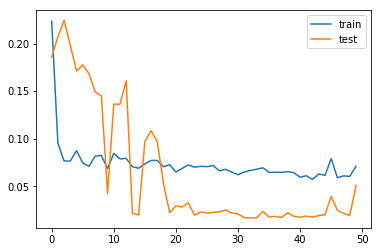

In [234]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
# fit network
history = model.fit(scaled_train_X, train_Y, epochs=50, batch_size=72, validation_data=(scaled_test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [235]:
test['pred'] = model.predict(scaled_test_X)

/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [238]:
from sklearn.metrics import classification_report

In [242]:
print(classification_report(test_Y, test['pred'].apply(lambda val: 1 if val > 0.5 else 0)))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     34304
          1       0.99      0.82      0.90      4307

avg / total       0.98      0.98      0.98     38611



In [268]:
scaled_train_X

array([[[ 0.18662968, -0.43087066, -0.33970499, ..., -0.51763575,
         -0.41373483, -0.01533561]],

       [[ 0.2317606 , -0.449097  , -0.33970499, ..., -0.51763575,
         -0.41373483, -0.01533561]],

       [[ 0.18697885, -0.43087066, -0.33970499, ..., -0.51763575,
         -0.41373483, -0.01533561]],

       ...,

       [[-1.640256  ,  2.70948319, -0.33970499, ..., -0.30568669,
         -0.12557963, -0.01533561]],

       [[-1.640256  ,  2.02717524, -0.33970499, ..., -0.17169341,
          0.05659085, -0.01533561]],

       [[-1.640256  ,  1.61811181, -0.33970499, ..., -0.51763575,
         -0.41373483, -0.01533561]]])

In [17]:
scaled_train_X = pd.DataFrame(scaled_train_X)

In [18]:
scaled_train_X.columns = train[[column for column in train.columns if column not in non_trainable]].columns

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=3)


In [39]:
scaled_train_X_pca = pca.fit_transform(scaled_train_X)

In [36]:
print(pca.explained_variance_ratio_) 

[0.21075867 0.1487434  0.12321603]


In [19]:
y = train[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0)

In [20]:
scaled_train_X['label'] = y

In [103]:
colors = ['navy', 'turquoise']

In [22]:
import matplotlib.pyplot as plt

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [156]:
scaled_train_X_pca = np.hstack((scaled_train_X_pca, np.array(train[' Label'].apply(lambda val: 1 if val == 'DDoS' else 0)).reshape(187134,1)))

In [173]:
th = 20

In [174]:
cleaned_data = np.array([row for row in scaled_train_X_pca if row[0] < th and row[0] > -th and row[1] < th and row[1] > -th and row[2] < th and row[2] > -th])

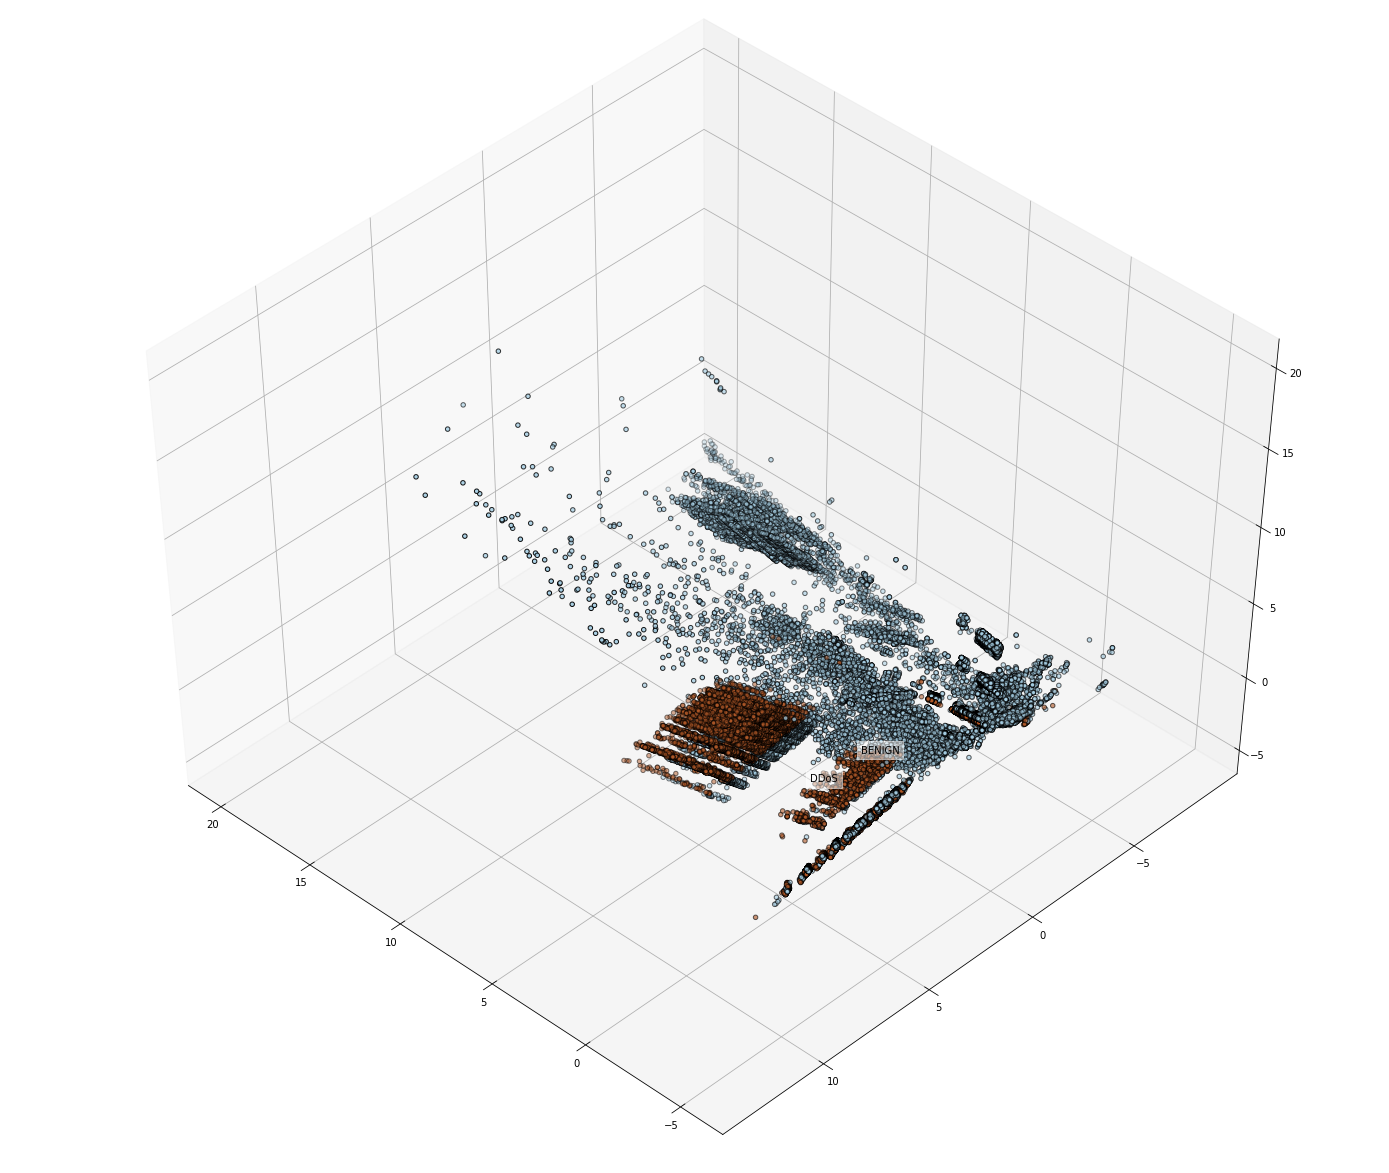

In [176]:
fig = plt.figure(1, figsize=(20,16))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
for name, label in [('BENIGN', 0), ('DDoS', 1)]:
    ax.text3D(np.array(cleaned_data)[cleaned_data[:,3] == label, 0].mean(),
              np.array(cleaned_data)[cleaned_data[:,3] == label, 1].mean() + 1.5,
              np.array(cleaned_data)[cleaned_data[:,3] == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
#y = np.choose(cleaned_data[:,3], [1, 0]).astype(np.float)
ax.scatter(cleaned_data[:, 0],cleaned_data[:, 1], cleaned_data[:, 2], c=cleaned_data[:, 3], cmap=plt.cm.Paired,
           edgecolor='k')

 Source Port
4.318826176226139


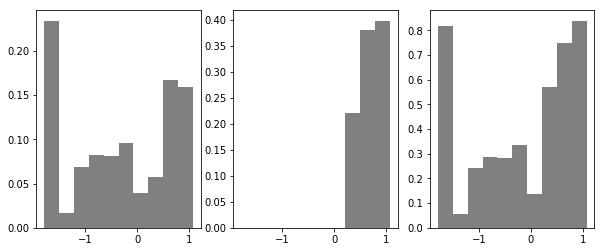

 Destination Port
1.3927994761615992


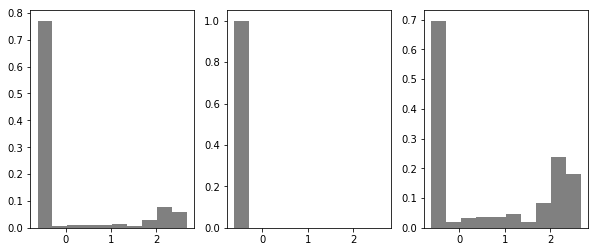

 Protocol
0.5122752139577642


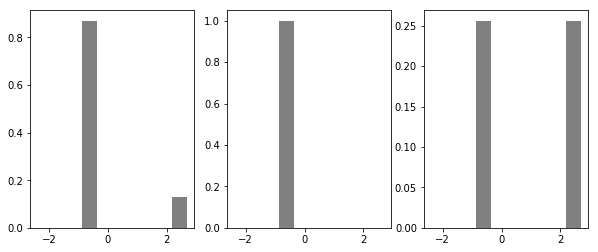

 Flow Duration
1.1931052133440971


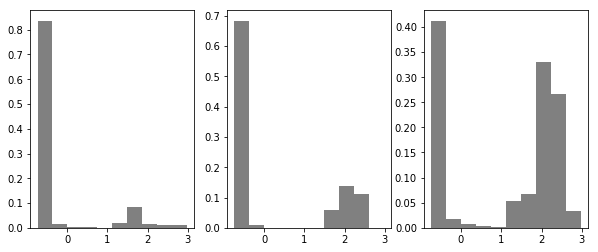

 Total Fwd Packets
8.550588137268278e-05


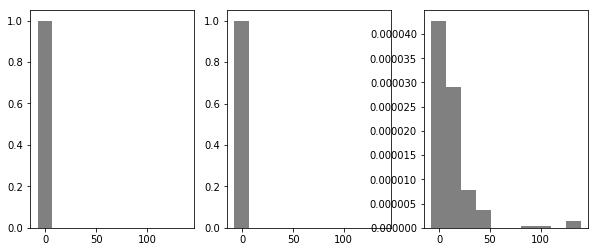

 Total Backward Packets
6.099091660871636e-05


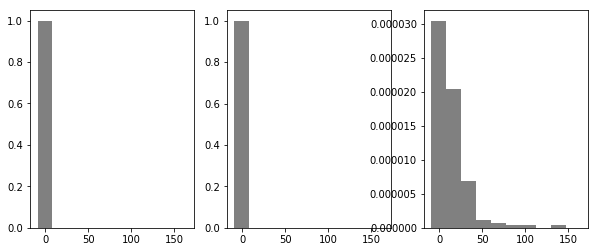

Total Length of Fwd Packets
0.005861742088882238


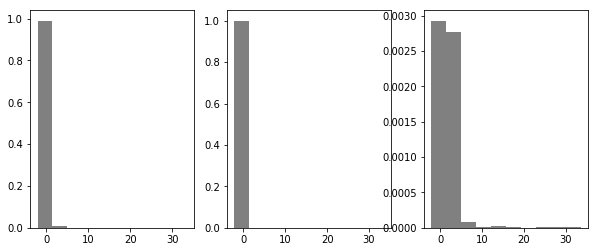

 Total Length of Bwd Packets
6.360018232953735e-05


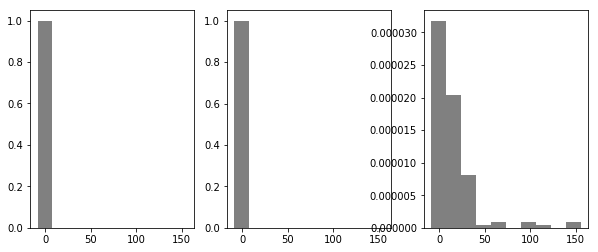

 Fwd Packet Length Max
0.4008884155191481


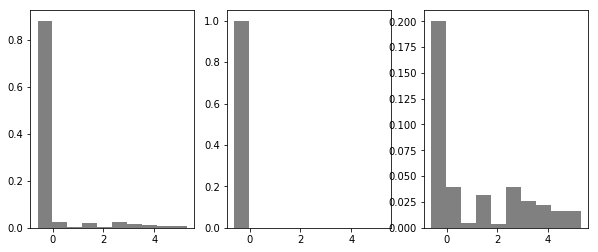

 Fwd Packet Length Min
0.045510992842537235


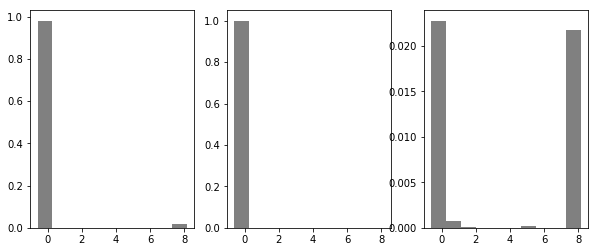

 Fwd Packet Length Mean
0.3186852453782194


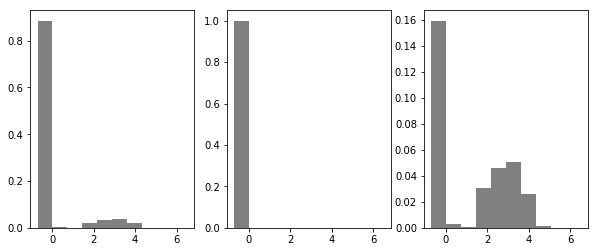

 Fwd Packet Length Std
0.24214505593226932


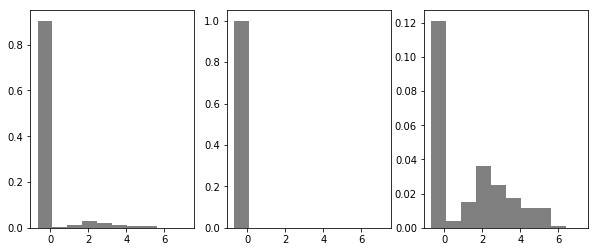

Bwd Packet Length Max
2.005295353010297


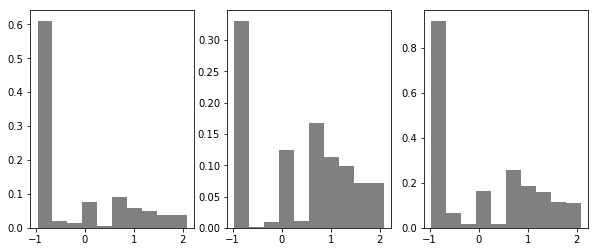

 Bwd Packet Length Min
0.010834817237309835


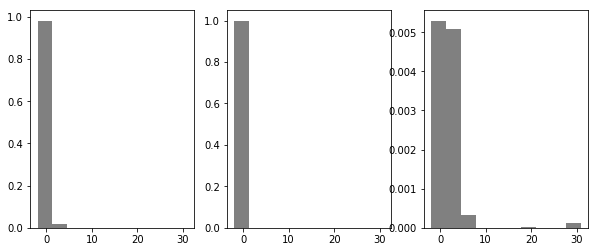

 Bwd Packet Length Mean
1.22613609297332


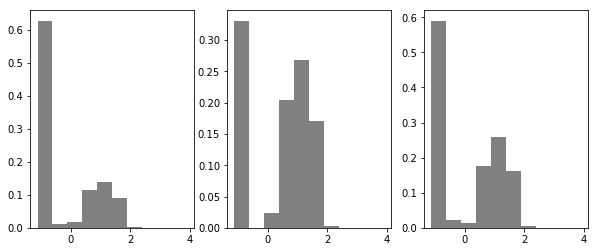

 Bwd Packet Length Std
1.3432330484502017


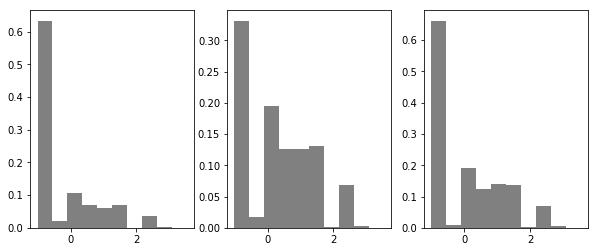

Flow Bytes/s
4.884994064013881e-05


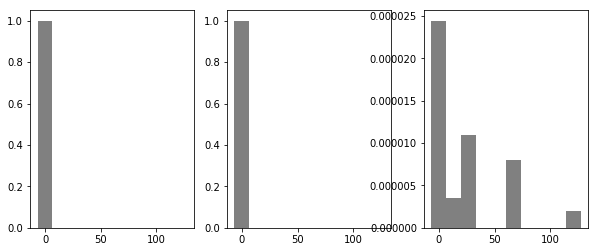

 Flow Packets/s
0.006945319260466931


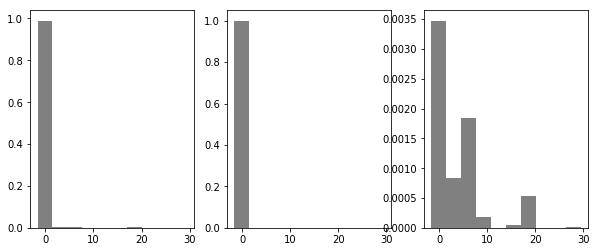

 Flow IAT Mean
0.1971759640291566


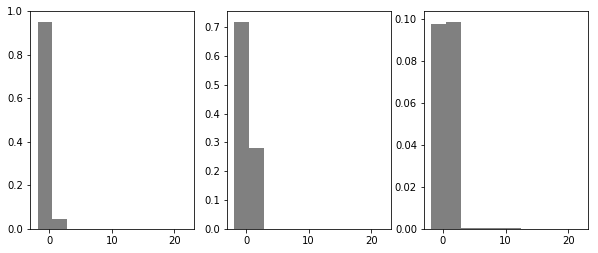

 Flow IAT Std
0.5502287885756232


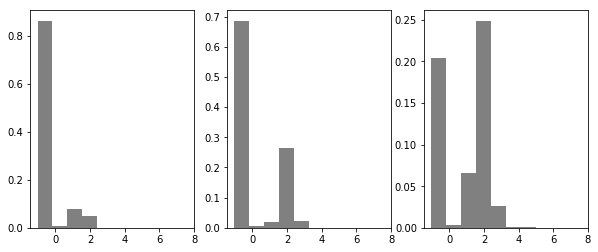

 Flow IAT Max
1.0957313405815512


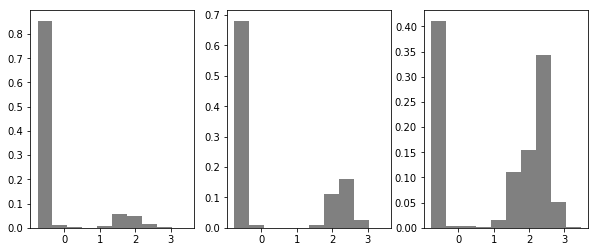

 Flow IAT Min
2.5846691926290077e-05


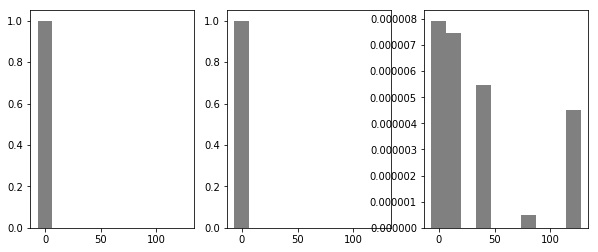

Fwd IAT Total
1.19188039470464


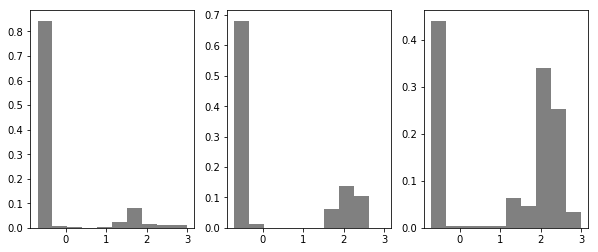

 Fwd IAT Mean
0.16539933244348504


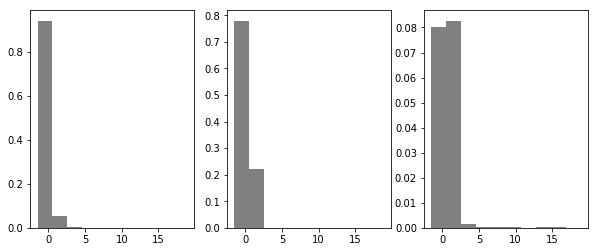

 Fwd IAT Std
0.6410786986307357


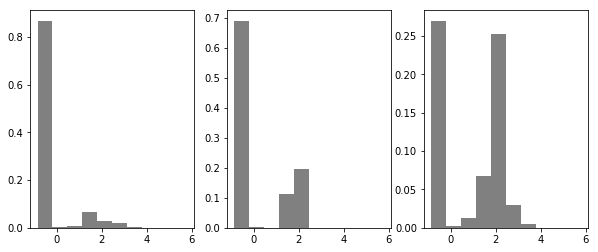

 Fwd IAT Max
1.0940911599900573


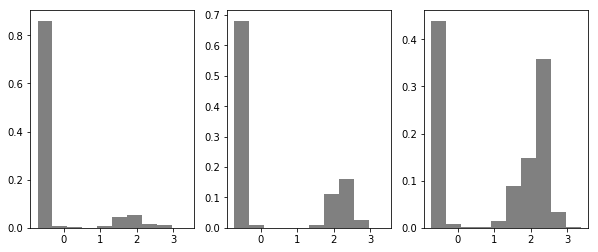

 Fwd IAT Min
0.001322328062087763


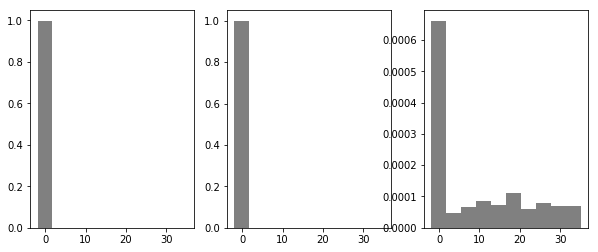

Bwd IAT Total
0.3165359254926443


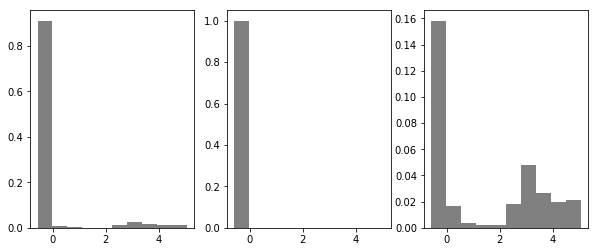

 Bwd IAT Mean
0.00826907640293939


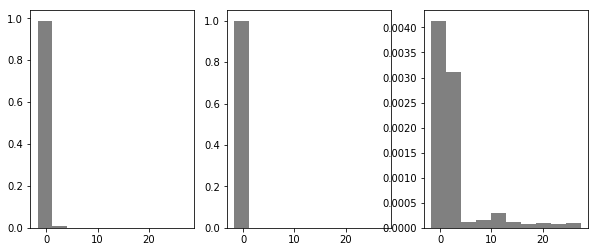

 Bwd IAT Std
0.09693064438761212


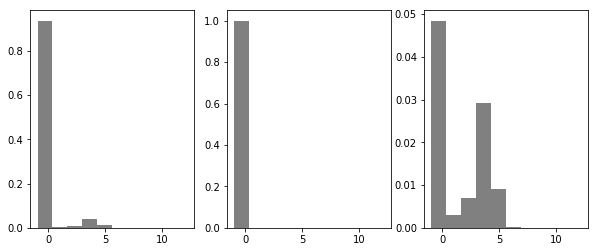

 Bwd IAT Max
0.1976690297597088


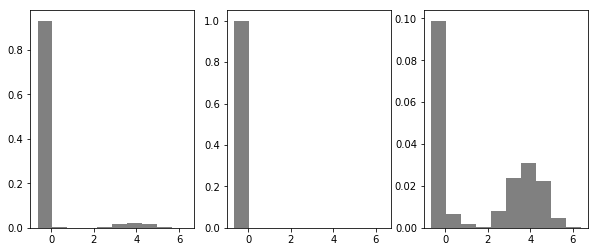

 Bwd IAT Min
0.001688661111984402


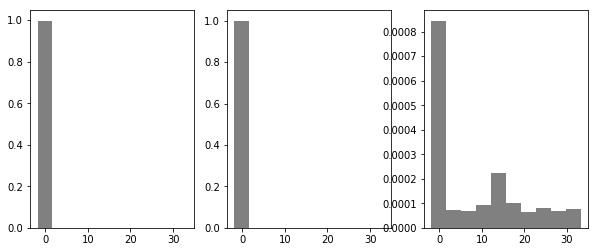

Fwd PSH Flags
0.1328280195593834


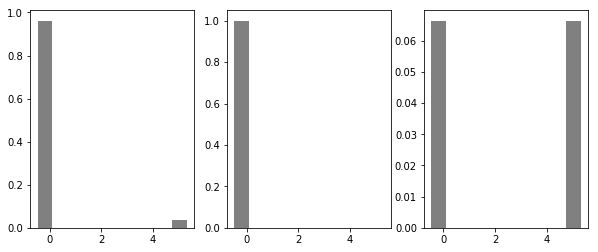

 Bwd PSH Flags
 Fwd URG Flags
 Bwd URG Flags
 Fwd Header Length
9.235950585662067e-05


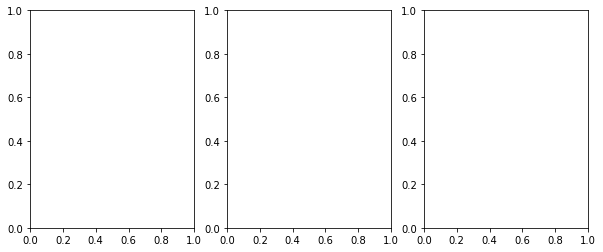

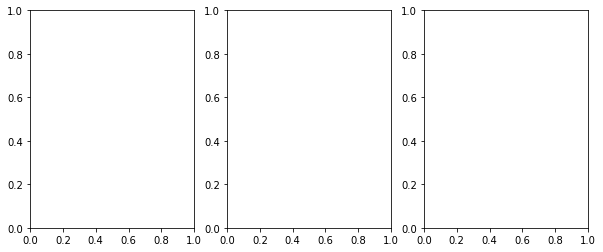

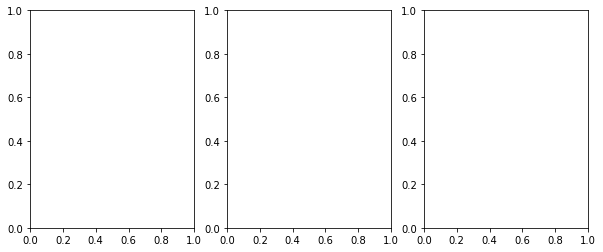

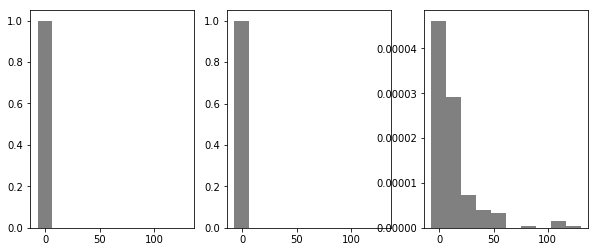

 Bwd Header Length
8.657616922391753e-05


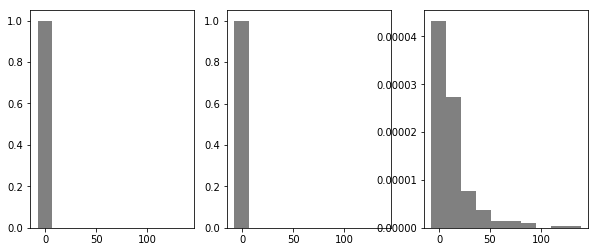

Fwd Packets/s
0.006525704332261739


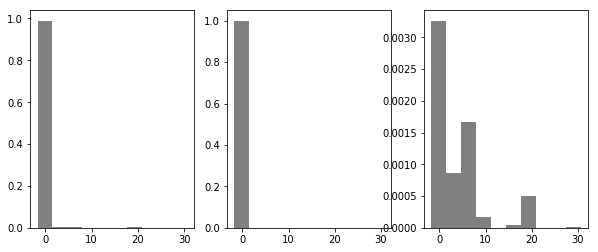

 Bwd Packets/s
9.06711472907773e-05


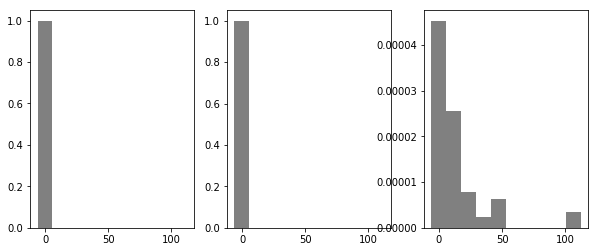

 Min Packet Length
0.11642502095855889


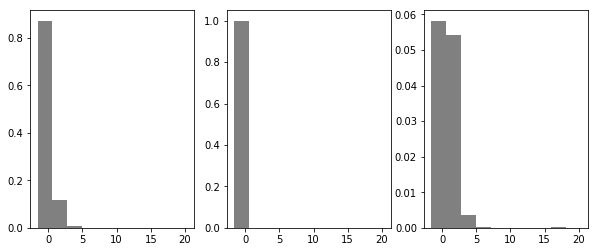

 Max Packet Length
1.426432082309475


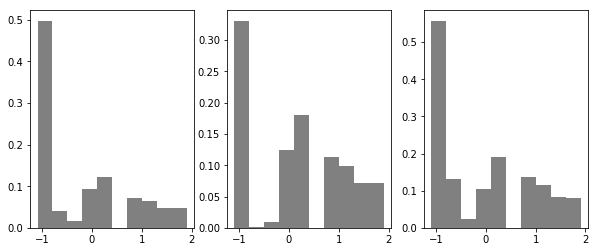

 Packet Length Mean
1.3815214447677135


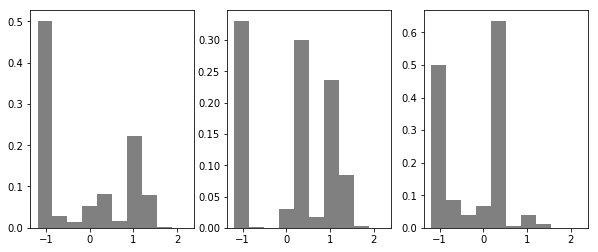

 Packet Length Std
1.193422450684011


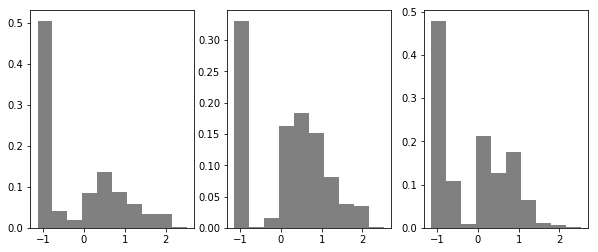

 Packet Length Variance
0.765264904970536


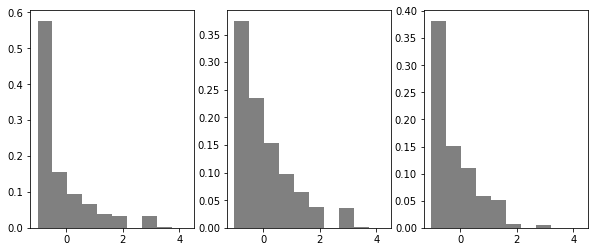

FIN Flag Count
0.0019186128629371524


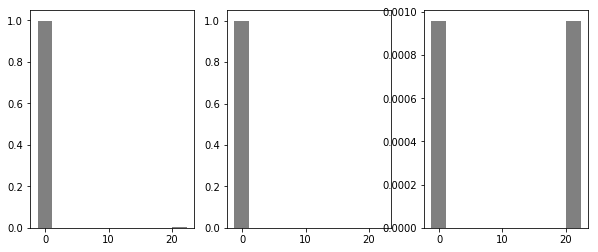

 SYN Flag Count
0.1328280195593834


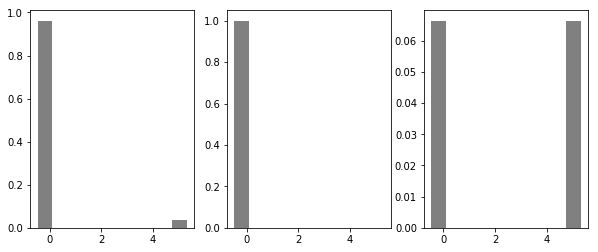

 RST Flag Count
4.539583642326761e-06


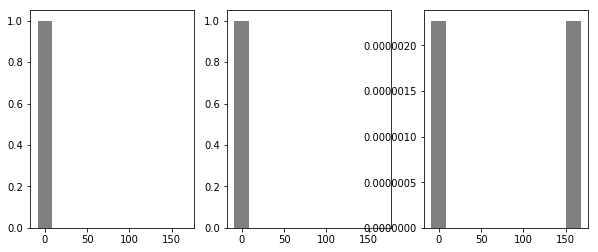

 PSH Flag Count
0.38327693939208984


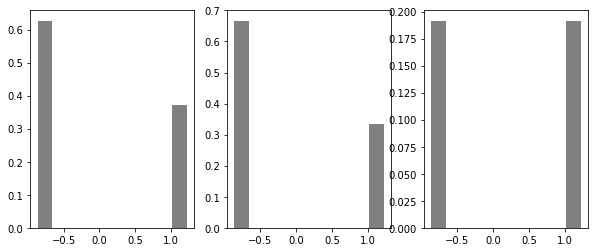

 ACK Flag Count
0.0


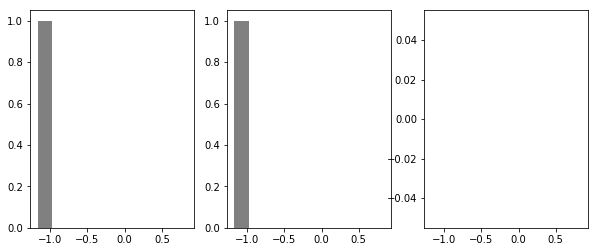

 URG Flag Count
1.3160052299499512


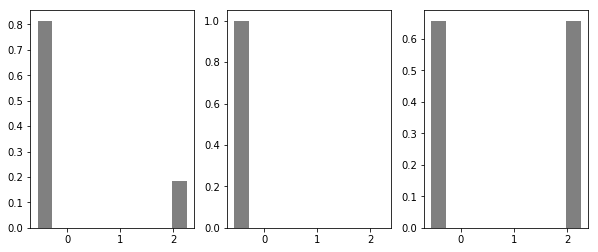

 CWE Flag Count
 ECE Flag Count
4.539583642326761e-06


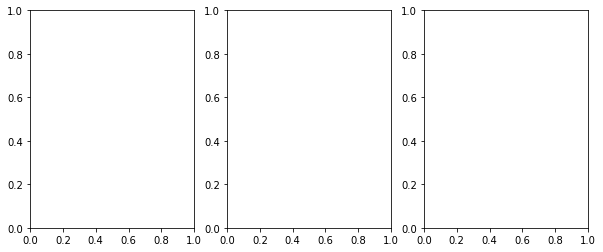

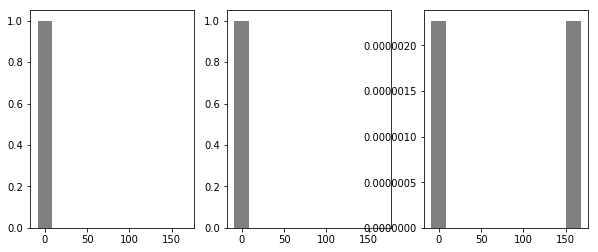

 Down/Up Ratio
1.236307165818289


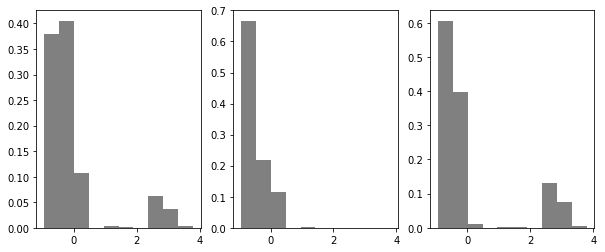

 Average Packet Size
1.1982355110667413


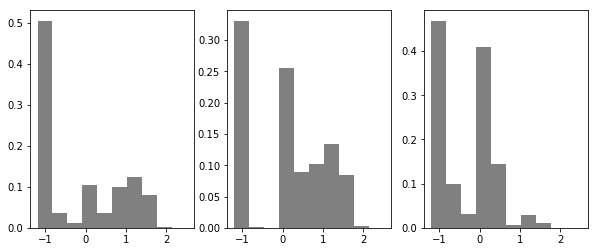

 Avg Fwd Segment Size
0.3186852453782194


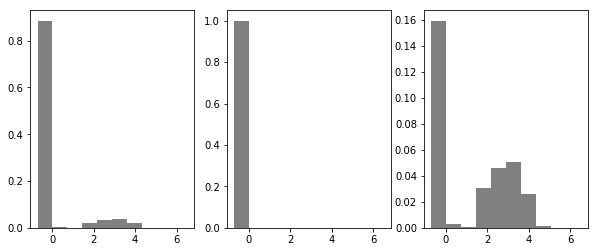

 Avg Bwd Segment Size
1.2261360333686753


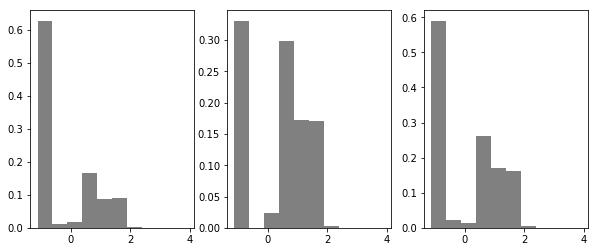

 Fwd Header Length.1
9.235950585662067e-05


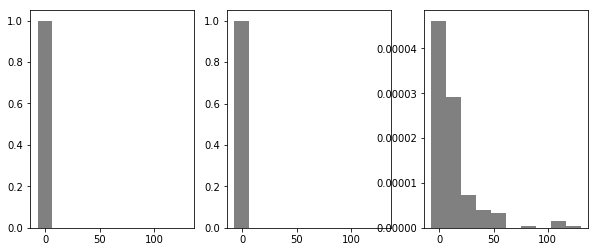

Fwd Avg Bytes/Bulk
 Fwd Avg Packets/Bulk
 Fwd Avg Bulk Rate
 Bwd Avg Bytes/Bulk
 Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate
Subflow Fwd Packets
8.550588137268278e-05


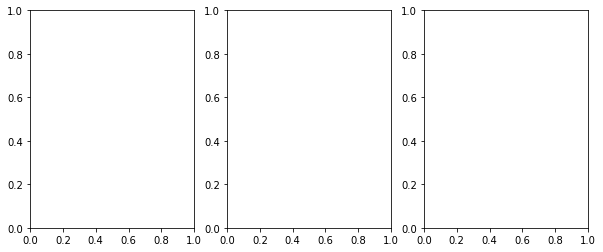

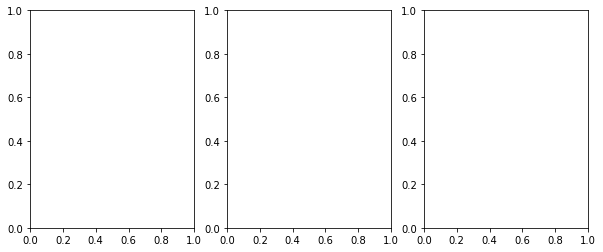

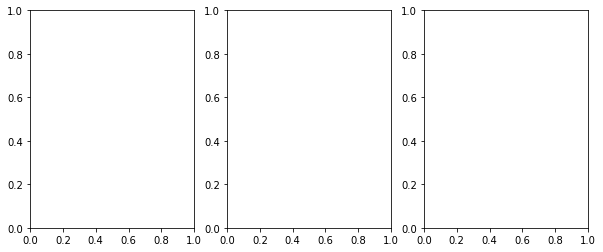

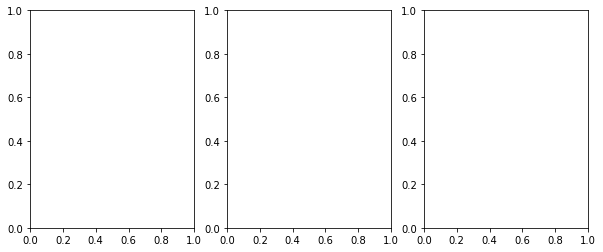

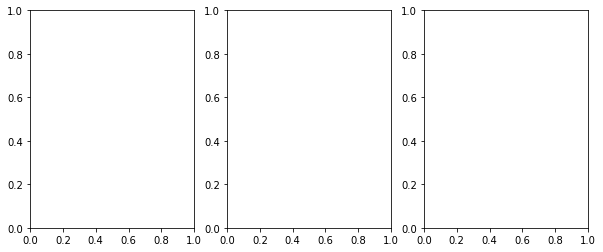

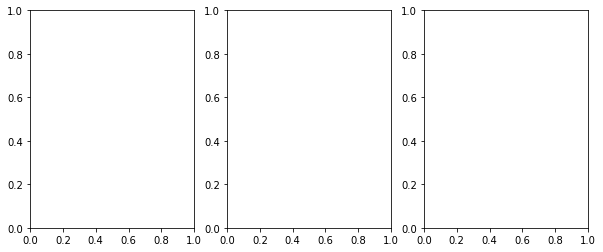

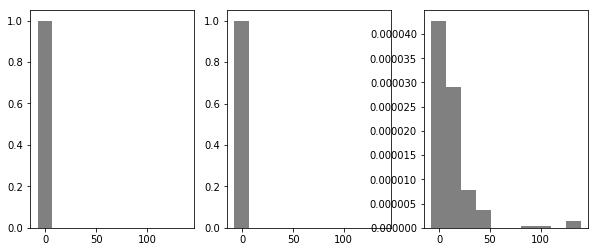

 Subflow Fwd Bytes
0.005861742088882238


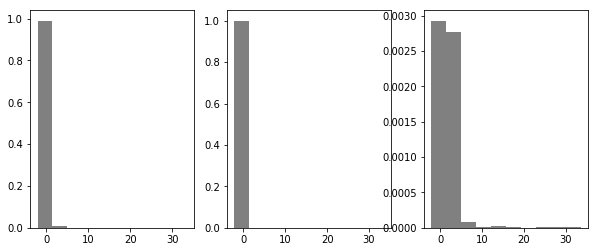

 Subflow Bwd Packets
6.099091660871636e-05


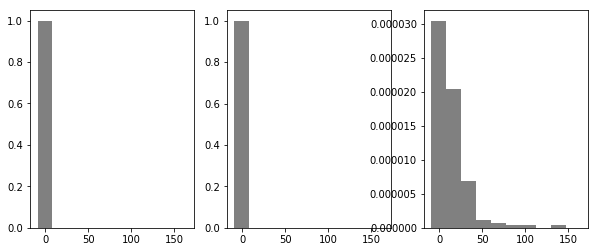

 Subflow Bwd Bytes
6.360018232953735e-05


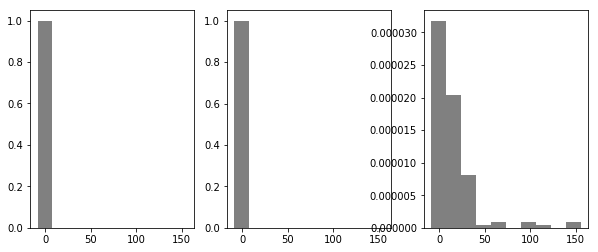

Init_Win_bytes_forward
0.09495967546763495


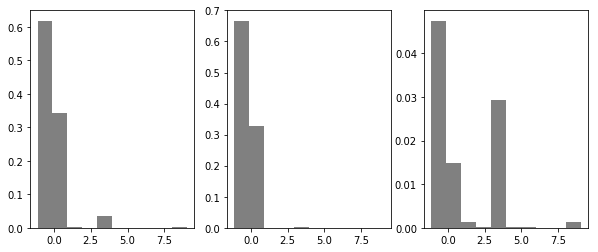

 Init_Win_bytes_backward
0.011226510629057884


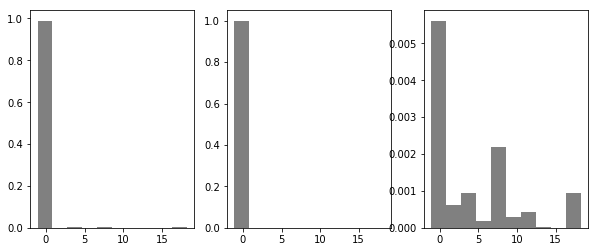

 act_data_pkt_fwd
4.339930069363618e-05


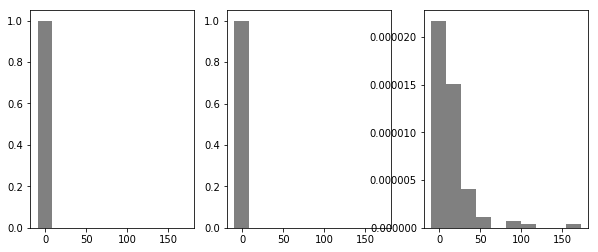

 min_seg_size_forward
0.1552444647604716


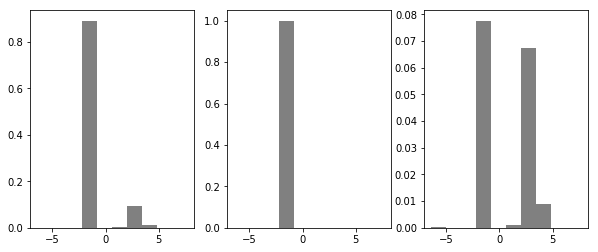

Active Mean
1.683971777310944e-05


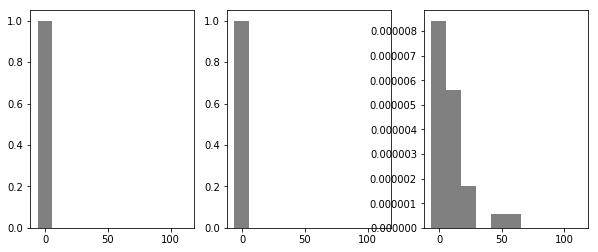

 Active Std
3.100896515206841e-05


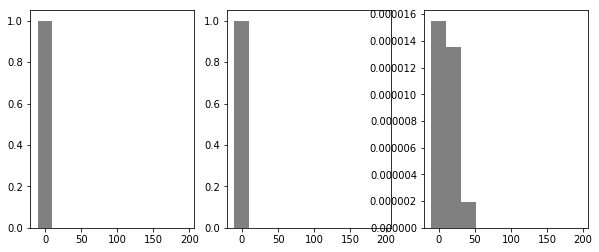

 Active Max
8.220795643865131e-05


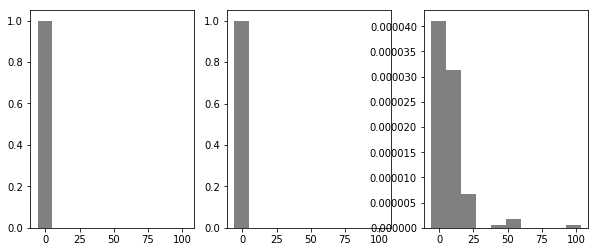

 Active Min
1.4409752111532725e-05


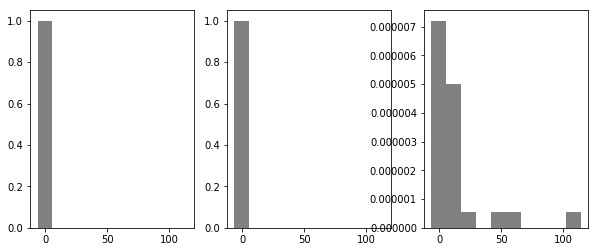

Idle Mean
0.787752490490675


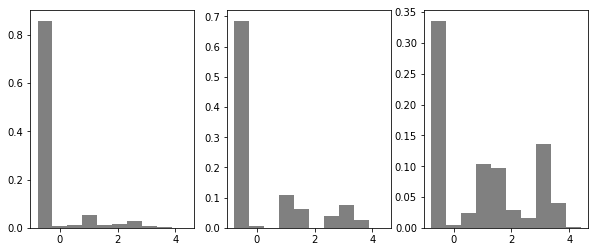

 Idle Std
0.5329646311583929


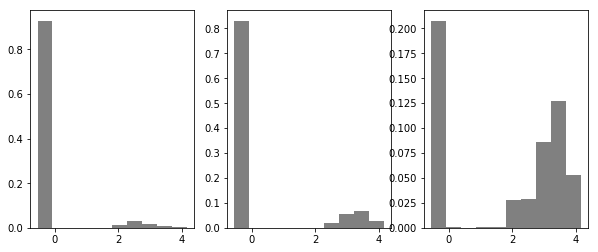

 Idle Max
1.1062398474896327


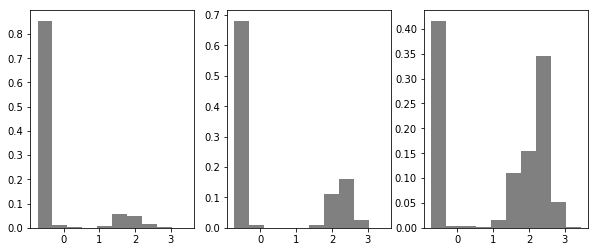

 Idle Min
0.35319047229131684


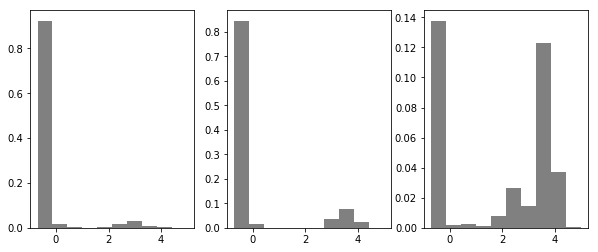

time_diff
3.2458756322739646e-05


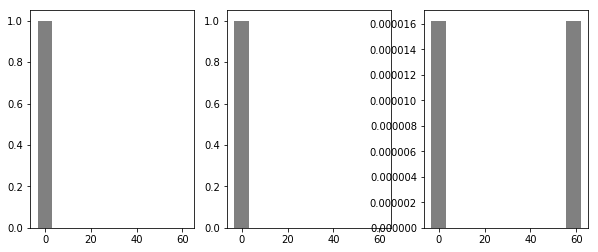

label
20.0


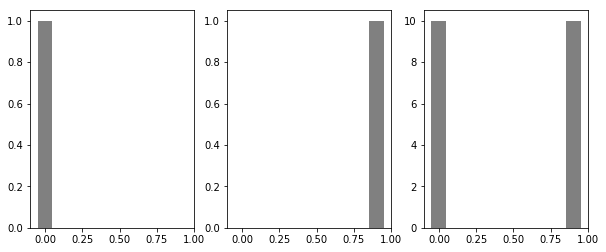

In [27]:
for col in scaled_train_X.columns:
    print(col)
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    min_col = scaled_train_X[col].min()
    max_col = scaled_train_X[col].max()
    if max_col - min_col > 0:
        use_bins = np.arange(min_col,max_col + 0.1 * max_col , (max_col - min_col) / 10)
        hist, bins = np.histogram(scaled_train_X.ix[scaled_train_X['label'] == 1,col], bins = use_bins, normed=True, density=True)
        ax[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum() , width=(bins[1]-bins[0]), color='grey')
        hist_2, bins_2 = np.histogram(scaled_train_X.ix[scaled_train_X['label'] == 0,col], bins = use_bins, normed=True, density=True)
        ax[0].bar(bins_2[:-1], hist_2.astype(np.float32) / hist_2.sum(), width=(bins_2[1]-bins_2[0]), color='grey')
        ax[2].bar(bins_2[:-1], np.absolute((hist_2.astype(np.float32)) - (hist.astype(np.float32))),width=(bins_2[1]-bins_2[0]), color='grey')
        print(sum(np.absolute((hist_2.astype(np.float32)) - (hist.astype(np.float32) ))))
        #scaled_train_X.ix[scaled_train_X['label'] == 0,col].hist(bins = 30, normed=True)
        #scaled_train_X.ix[scaled_train_X['label'] == 1,col].hist(bins = 30, normed=True)
        plt.show()